In [1]:
import numpy as np
import yt
import magnetic_field
import util
from params import Params
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

In [2]:
util.constants.m_p * util.thermal_velocity(600, util.constants.m_p)/util.constants.e/0.3

0.011797662958747044

In [21]:
util.larmor_radius(params.m_i, util.thermal_velocity(1,params.m_i), util.constants.e, 0.03)

0.0022479982079524493

In [26]:
lr = util.larmor_radius(params.m_e, util.thermal_velocity(300,params.m_e), util.constants.e, 0.3/2)
print(lr, 0.01 / lr)

0.0003893647111497427 25.682861629836246


In [35]:
dt = 0.1 / util.cyclotron_freq(params.m_e, 0.3)
t = 0.05 / util.thermal_velocity(1, params.m_i)
steps = t / dt
steps

889680.4245327518

In [29]:
util.debye_length(1, 1e19)

2.3495723015051058e-06

In [3]:
dirname = f"diags202312061915"
params = Params()
params.load(f"{dirname}/params.json")
# specs, time_data = util.extract_data(f"{dirname}/output.log")

yt : [INFO     ] 2023-12-06 14:17:45,626 Parameters: current_time              = 9.476050172609537e-11
yt : [INFO     ] 2023-12-06 14:17:45,627 Parameters: domain_dimensions         = [ 160 1600    1]
yt : [INFO     ] 2023-12-06 14:17:45,627 Parameters: domain_left_edge          = [ 0.   -0.05  0.  ]
yt : [INFO     ] 2023-12-06 14:17:45,628 Parameters: domain_right_edge         = [0.01 0.05 1.  ]


yt : [INFO     ] 2023-12-06 14:17:45,835 xlim = 0.000000 0.010000
yt : [INFO     ] 2023-12-06 14:17:45,836 ylim = -0.050000 0.050000
yt : [INFO     ] 2023-12-06 14:17:45,838 xlim = 0.000000 0.010000
yt : [INFO     ] 2023-12-06 14:17:45,839 ylim = -0.050000 0.050000
yt : [INFO     ] 2023-12-06 14:17:45,841 Making a fixed resolution buffer of (('boxlib', 'n_electrons')) 800 by 800
yt : [INFO     ] 2023-12-06 14:17:46,128 Making a fixed resolution buffer of (('boxlib', 'normed_phi')) 800 by 800
yt : [INFO     ] 2023-12-06 14:17:46,219 Making a fixed resolution buffer of (('boxlib', 'n_ions')) 800 by 800



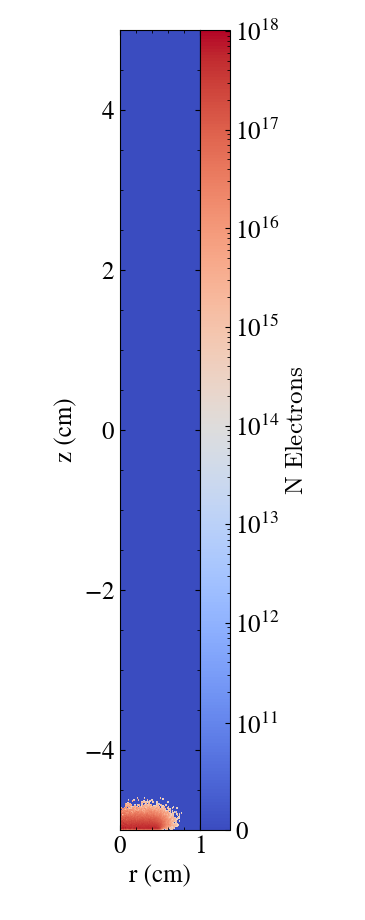
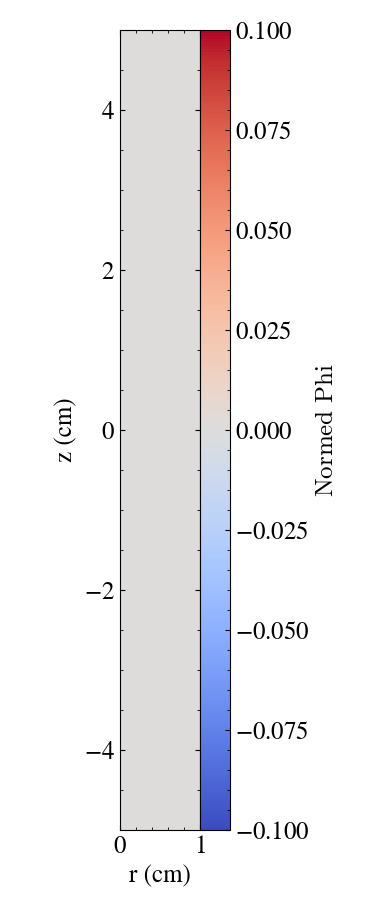
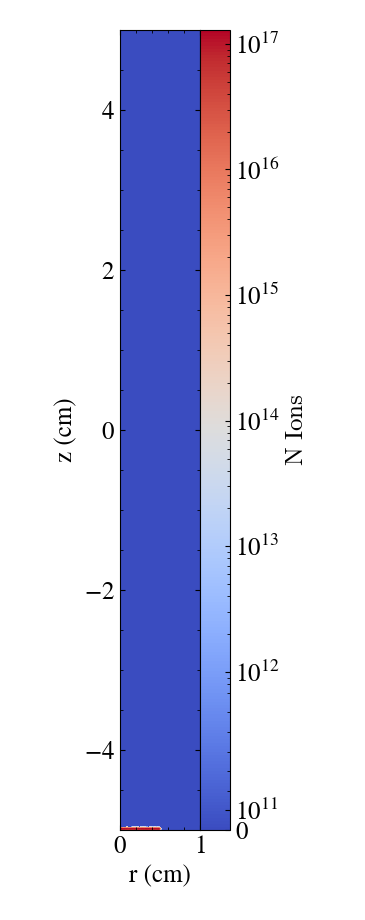

In [5]:
step = 10
fields = [('boxlib', 'n_electrons'), ('boxlib', 'n_ions'), ('boxlib', 'normed_phi')]
ds = yt.load(f"{dirname}/diag{step:06d}/")
ds.add_field(
    ("boxlib", "n_electrons"),
    function=lambda field, data: -data["boxlib", "rho_electrons"]/util.constants.e,
    units="1",
    sampling_type="cell",
)
ds.add_field(
    ("boxlib", "n_ions"),
    function=lambda field, data: data["boxlib", "rho_ions"]/util.constants.e,
    units="1",
    sampling_type="cell",
)
ds.add_field(
    ("boxlib", "normed_phi"),
    function=lambda field, data: data["boxlib", "phi"]/params.T_e,
    units="1",
    sampling_type="cell",
)
p = yt.SlicePlot(ds, "z", fields, origin="native");
p.set_cmap(fields, "coolwarm")
p.set_xlabel("r (cm)")
p.set_ylabel("z (cm)")
# p.annotate_title(f"Time={time_data[step-1][1] * 1e9 : .3f}ns")
p.show();
# p.save()


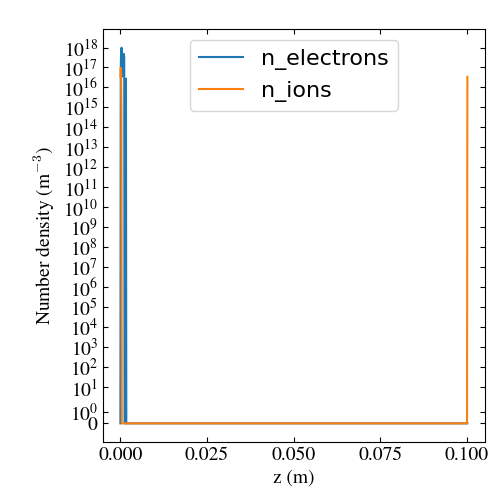


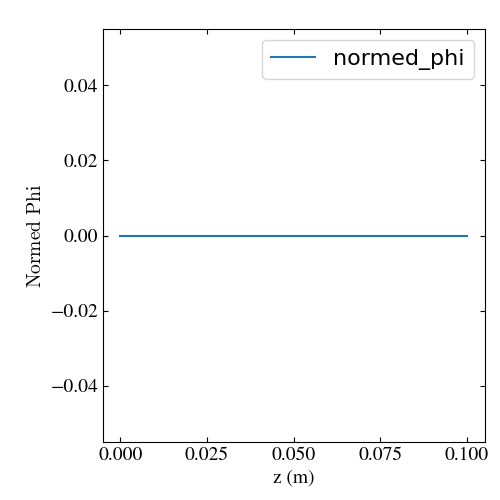

In [8]:
p = yt.LinePlot(ds, fields[:-1], (0,-0.05,0), (0,0.05,0), 1000)
p.annotate_legend(fields[0])
p.set_xlabel("z (m)")
p.set_ylabel("Number density (m$^{-3}$)")
# p.annotate_title(fields[:-1], f"Time={time_data[step-1][1] * 1e9 : .3f}ns")
p.show()
# p.save()
p = yt.LinePlot(ds, fields[-1], (0,-0.05,0), (0,0.05,0), 1000)
p.annotate_legend(fields[-1])
p.set_xlabel("z (m)")
# p.annotate_title(fields[-1], f"Time={time_data[step-1][1] * 1e9 : .3f}ns")
p.set_log(fields[-1], log=False)
p.show()
# p.save()

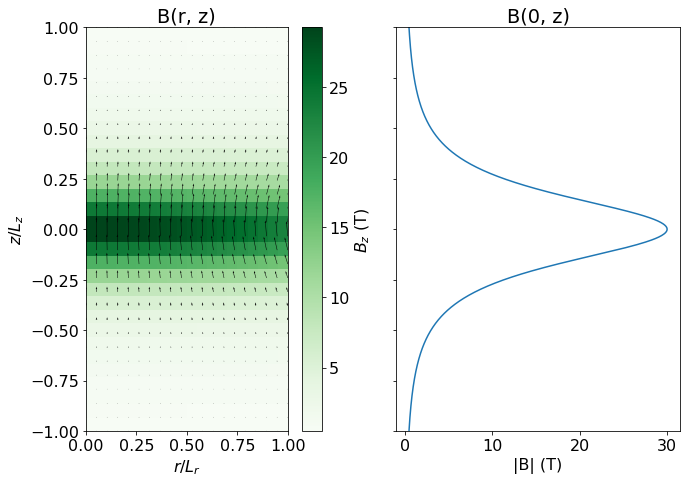

In [37]:
coil = magnetic_field.CoilBField(R=params.R_coil, B_max=params.B_max)
r_grid = np.linspace(0, 1, 20)
z_grid = np.linspace(-1, 1, 30)

rr, zz = np.meshgrid(r_grid, z_grid)
Br, Bz = coil.get_B_field(rr*params.Lr, zz*params.Lz)

# creating plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 7))

ax1.quiver(rr, zz, Br, Bz)
ax1.set_xlabel(f"$r/L_r$")
ax1.set_ylabel(f"$z/L_z$")
ax1.set_title("B(r, z)")

c = ax1.imshow(
    Bz, cmap='Greens',
    extent=[r_grid[0], r_grid[-1], z_grid[0], z_grid[-1]],
    aspect='equal', origin='lower'
)
bar = plt.colorbar(c, ax=ax1)
bar.set_label("$B_z$ (T)")

z_grid = np.linspace(z_grid[0], z_grid[-1], 800)
Br, Bz = coil.get_B_field(0, z_grid*params.Lz)
ax2.plot(Bz, z_grid)
ax2.set_xlabel("|B| (T)")
ax2.set_title("B(0, z)")

# show plot
plt.tight_layout()
# plt.savefig('B_field.png')
# plt.show()